# Time Series Anaysis

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

# Homework: Exploration of the Bay Area Rapid Transit (BART) data 
Bay Area Rapid Transit (BART) is a rapid transit public transportation system serving the San Francisco Bay Area in California. The provided dataset includes daily total ridership records in 2017, 2018, and 2019. In this homework, we aim to use trend + seasonality linear regression to predict BART ridership and detect anomalies using the timeseries decomposition method.

In [2]:
bart = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/bart.csv')

In [3]:
bart.head()

,date,passenger
0,2017-01-01,122773
1,2017-01-02,139245
2,2017-01-03,366495
3,2017-01-04,388842
4,2017-01-05,407099


In [4]:
bart.tail()

,date,passenger
1090,2019-12-27,229101
1091,2019-12-28,136422
1092,2019-12-29,83354
1093,2019-12-30,257428
1094,2019-12-31,225352


### Task 1, use linear regression to explore the trends over 3 years, and report is there a significant trend in the BART data.
Hint: using the index to represent the day count from the first day.

10 pts. -3 pts if the linear regression summary is missing.

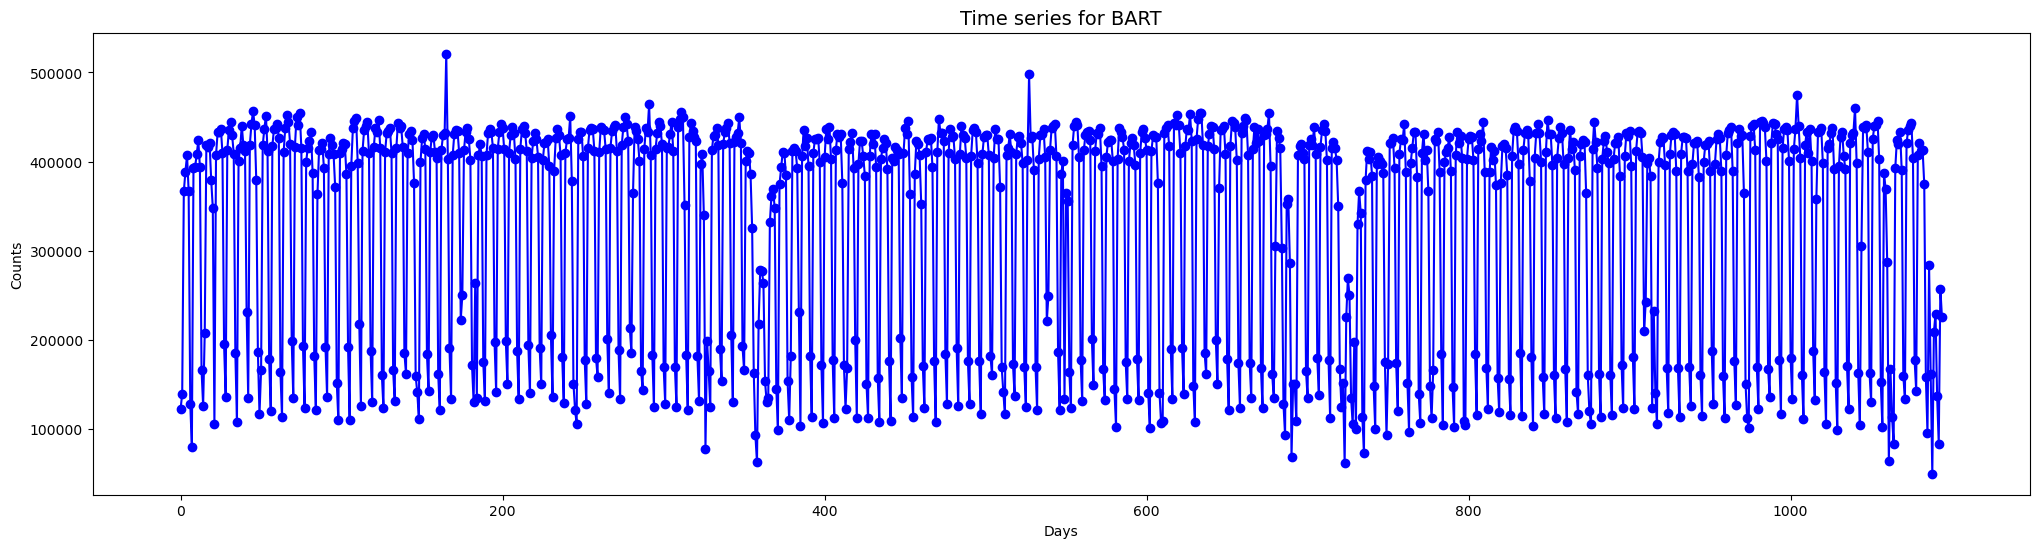

In [5]:
plt_1 = plt.figure(figsize=(25, 6))
plt.plot(bart.index,bart.passenger, color='blue', marker='o')

plt.title('Time series for BART', fontsize=14)
plt.xlabel('Days', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.show()

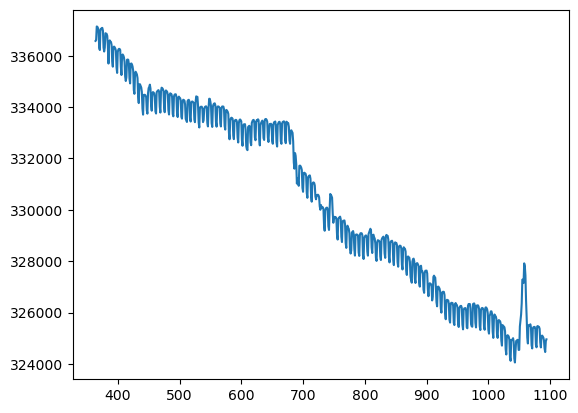

In [19]:
plt.plot(bart.passenger.rolling(window = 365).mean());## Weekly trend graph of rolling average

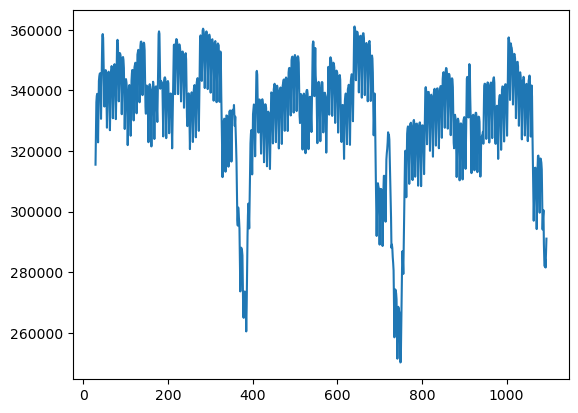

In [7]:
plt.plot(bart.rolling(window = 30).mean());## monthly trend graph of rolling average

In [8]:
lm=sm.OLS(bart.passenger,sm.add_constant(bart.index)).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.272
Date:                Mon, 06 Feb 2023   Prob (F-statistic):              0.132
Time:                        13:51:01   Log-Likelihood:                -14433.
No. Observations:                1095   AIC:                         2.887e+04
Df Residuals:                    1093   BIC:                         2.888e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.407e+05   7754.413     43.936      0.0

Therefore, with a p-value of .132 for X1, it is not possible to establish a trend based on the relationship between X1 and the response variable

### Task 2 Find a proper period using scipy.signal.periodogram and autocorrelation

10 pts for finding the period. -3 pts if the figure has an improper ylim.
10 pts for autocorrelation. -5 pts if used the wrong period.

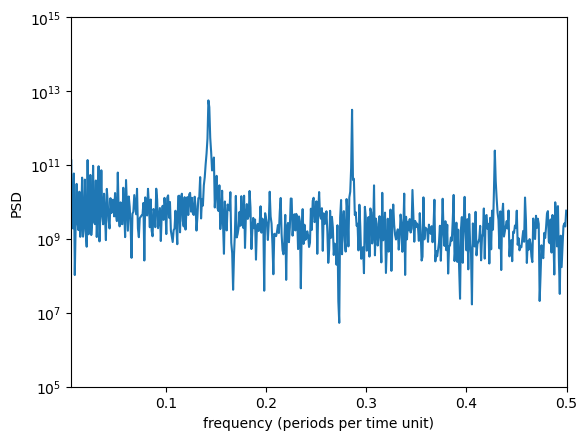

Strongest period length = 7.019230769230769


In [22]:
f, PSD = scipy.signal.periodogram(bart['passenger'])
plt.semilogy(f, PSD)
plt.xlabel('frequency (periods per time unit)')
plt.ylabel('PSD')
plt.xlim(0.005, 0.5) ## Period between 
plt.ylim(1e5,1e15) 

PSD = PSD[f>0.01]
f = f[f>0.01] 
plt.show()
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)])) #report the length of the strongest period

#transformting the frequency into the period length, using 1=frequency (number of periods)*period length

<function matplotlib.pyplot.show(close=None, block=None)>

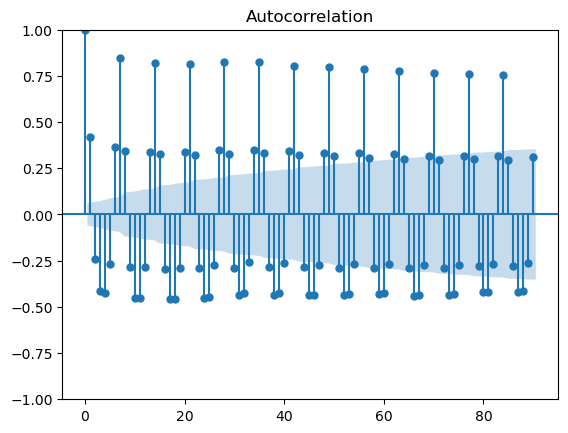

In [14]:
plot_acf(bart.passenger, lags = 90)
plt.show

### Task 3 Build a linear regression for trend+seasonality (using a weekly period with 7 dummy variables for each day of the week) to predict passenger count. Train on 2017 and 2018, test on 2019. Visualize the coefficients for each day of the week and analyze their significance

In [11]:
bart['DOW'] = pd.to_datetime(bart.date).dt.dayofweek 

In [12]:
X = pd.concat([pd.DataFrame(range(bart.shape[0]),columns=['day']),pd.get_dummies(bart['DOW'],drop_first=False)],axis=1)
#X = sm.add_constant(X) #we do not need an intercept as we have an individual constant for each day of the week (drop_first = False)
#alternatively we can add a constant but then exclude a dummy for Monday using drop_first = True - will do so below
lm=sm.OLS(bart.passenger[:730],X[:730]).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     512.6
Date:                Mon, 06 Feb 2023   Prob (F-statistic):          3.58e-275
Time:                        13:51:03   Log-Likelihood:                -8961.8
No. Observations:                 730   AIC:                         1.794e+04
Df Residuals:                     722   BIC:                         1.798e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day          -22.1202      9.170     -2.412      0.0

(100000.0, 450000.0)

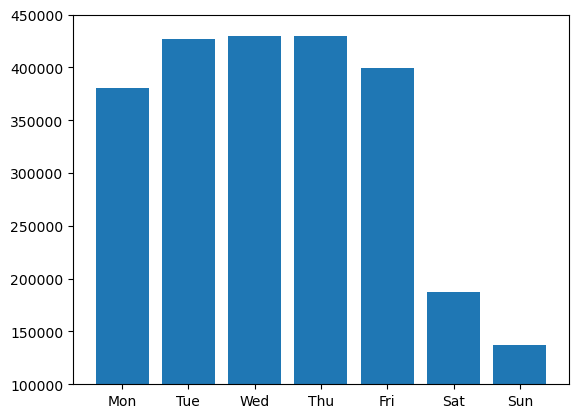

In [24]:
# visualize the effect of each day of week on taxi ridership
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        lm.params[1:].tolist())
plt.ylim([100000,450000])

### Task 4, plot results and report insample and out-of-sample predictions. Report in-sample and out-of-sample $R^2$

<function matplotlib.pyplot.show(close=None, block=None)>

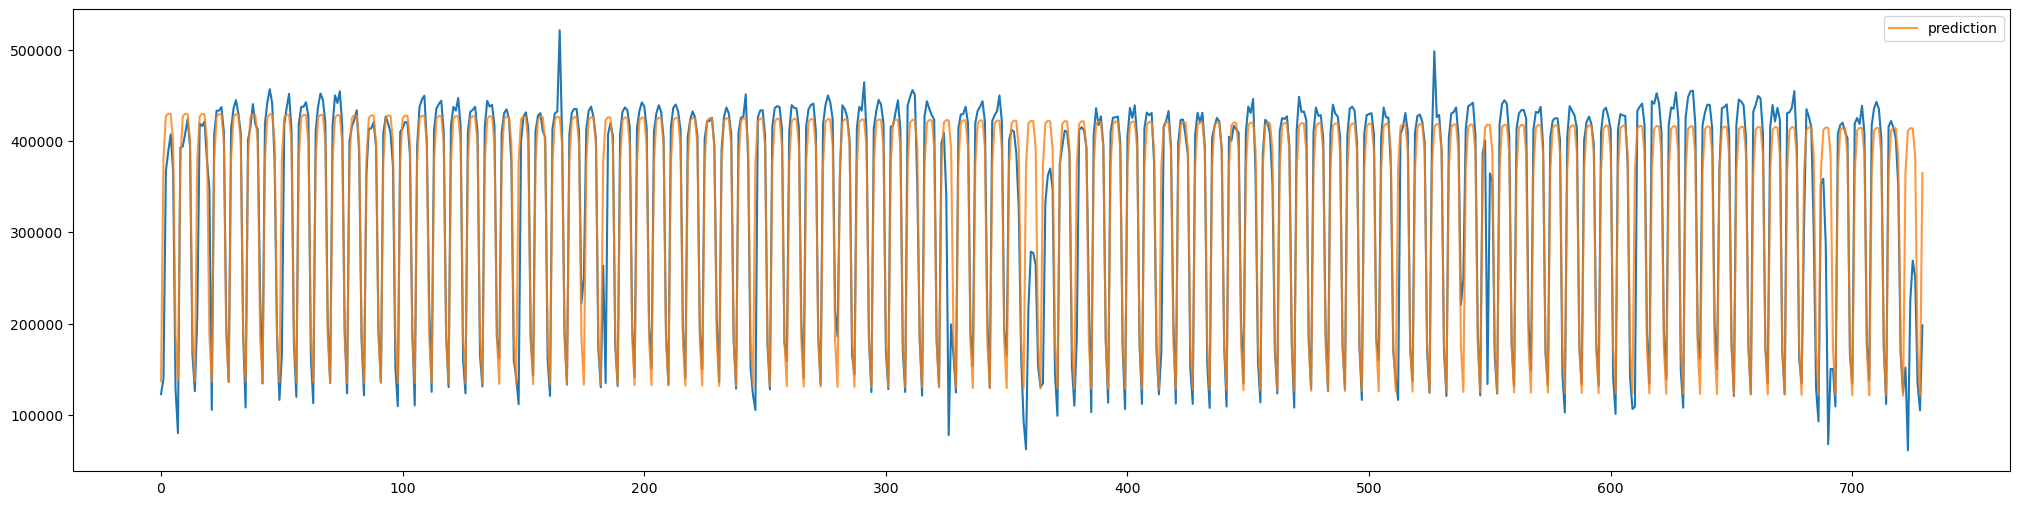

In [25]:
y1 = lm.predict(X[:730])
#visualize the actual ridership vs the model prediction
plt_1 = plt.figure(figsize=(25, 6))
plt.plot(bart.index[:730],bart.passenger[:730])
plt.plot(bart.index[:730],y1,label='prediction',alpha=0.8)
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

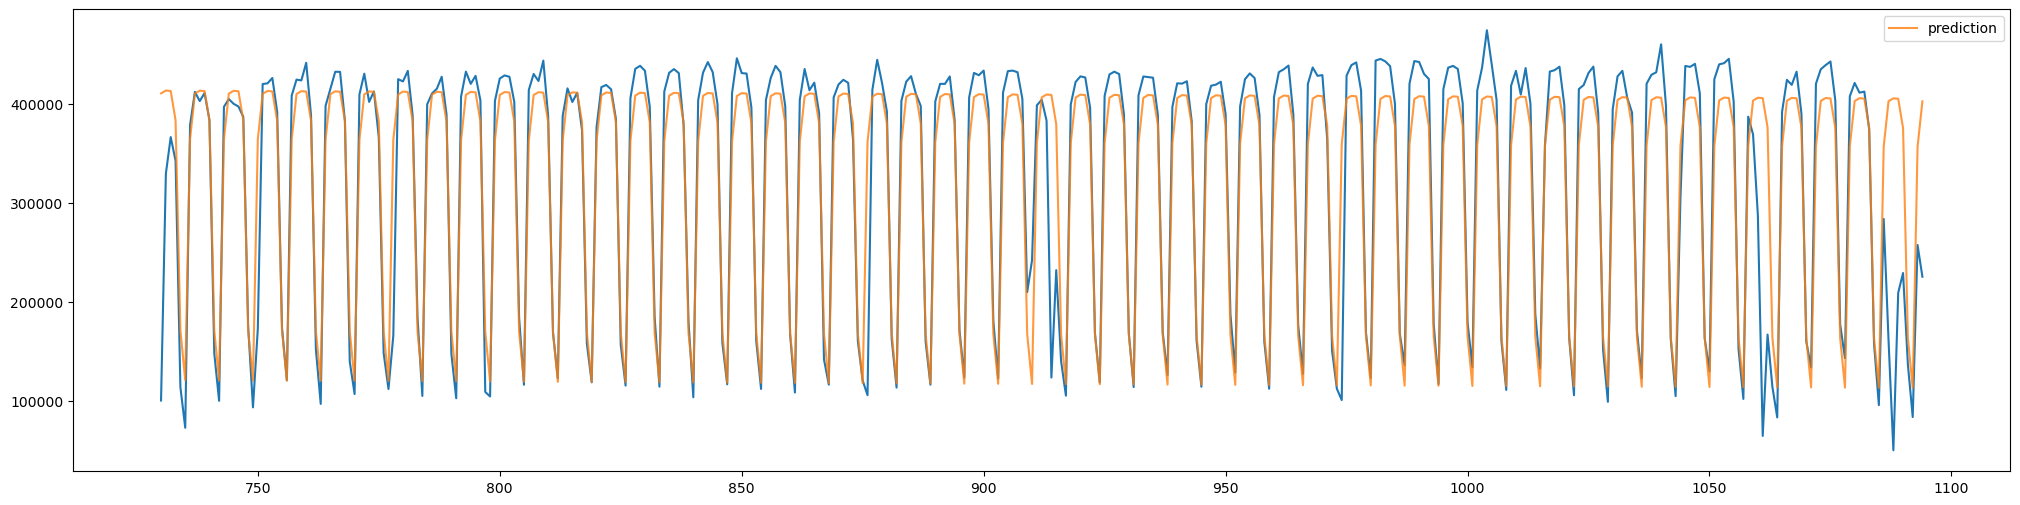

In [20]:
## Out of Sample Accuracy plot
y = lm.predict(X[730:])
#visualize the actual ridership vs the model prediction
plt_1 = plt.figure(figsize=(25, 6))
plt.plot(bart.index[730:],bart.passenger[730:])
plt.plot(bart.index[730:],y,label='prediction',alpha=0.8)
plt.legend()
plt.show

In [27]:
r2_score(bart.passenger[:730],y1[:730])## Insample R2 score  

0.8324941917707158

In [35]:
r2_score(bart.passenger[730:1095],y[:1095])## Out of sample R2 testing

0.8203089387540559

### Task 5, Use the "multiplicative" seasonal_decompose with 7 day period to decompose the BART data and detect outliers based on the top and bottom 2.5% of the residuals

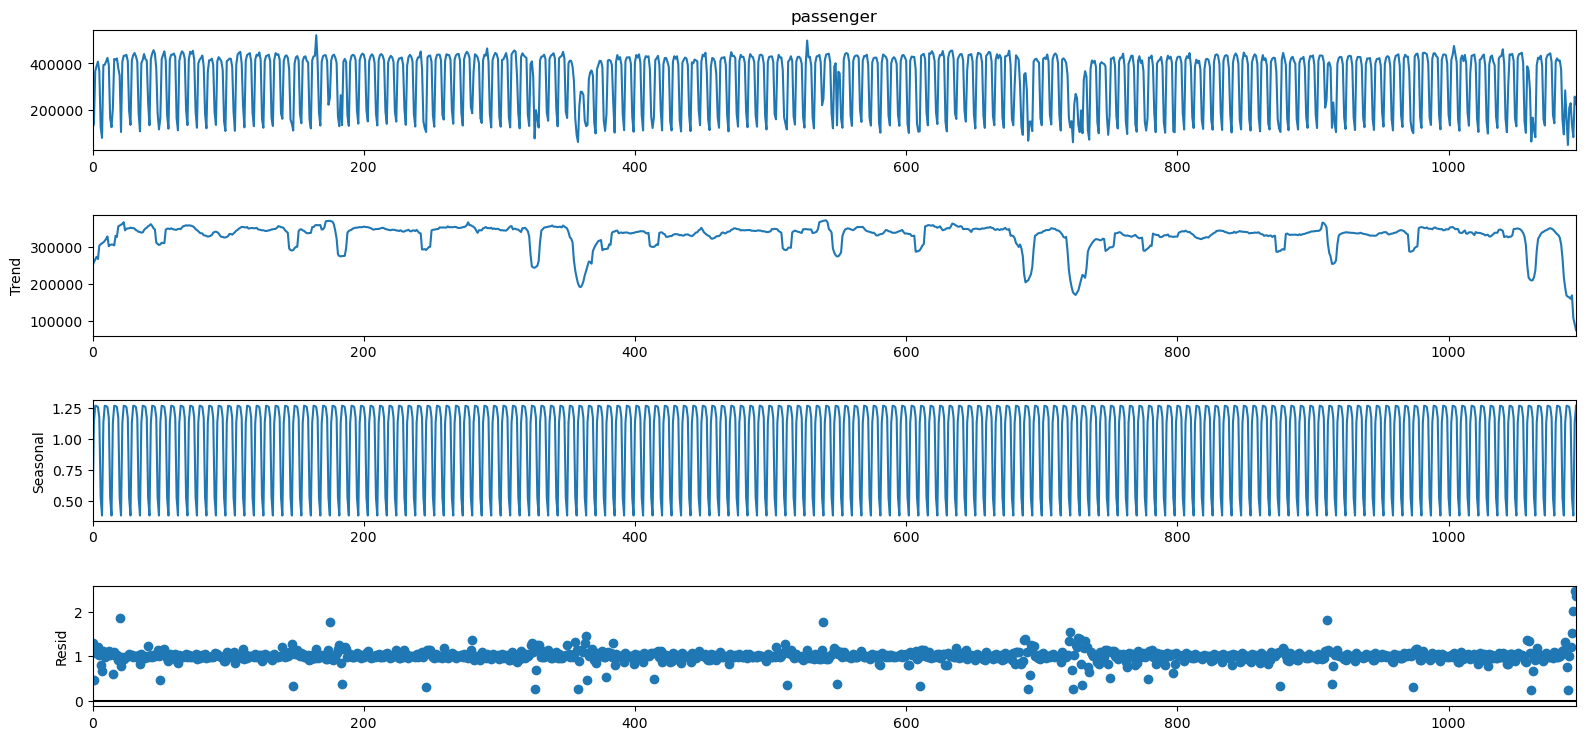

In [46]:
dailyDecomp = seasonal_decompose(bart.passenger, model='multicative', period = 7, extrapolate_trend='freq')
residualMult = np.array(dailyDecomp.resid)
resMult = dailyDecomp.resid
fig = dailyDecomp.plot()
fig.set_size_inches(18, 8)

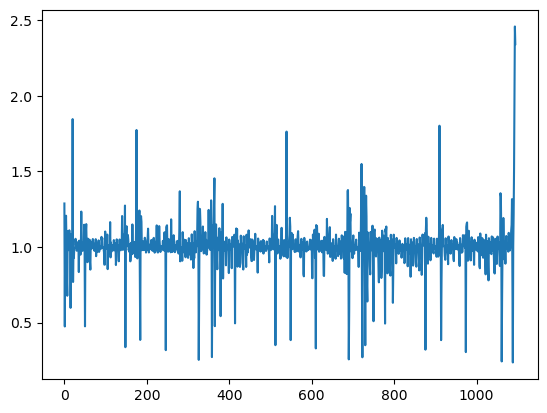

In [47]:
plt.show()
plt.plot(resMult);

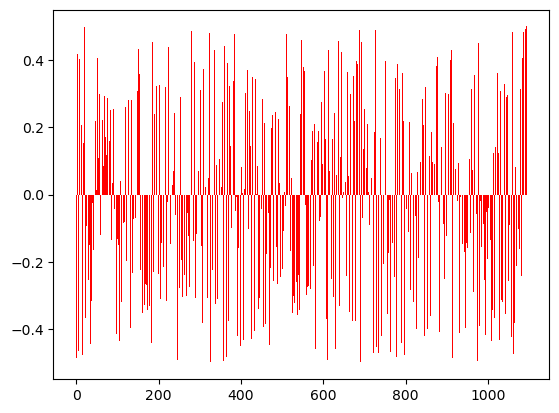

In [48]:
outlierData = pd.DataFrame()
outlierData['Res'] = residualMult
outlierData['Percentile_rank'] = outlierData.Res.rank(pct = True)-0.5
plt.bar(np.arange(0, len(outlierData)), outlierData['Percentile_rank'], color='red')
plt.show()

In [49]:
bart[outlierData['Percentile_rank']>0.475]## Outliers above 2.5% 

,date,passenger,DOW
0,2017-01-01,122773,6
20,2017-01-21,348146,5
147,2017-05-28,140909,6
175,2017-06-25,250259,6
280,2017-10-08,185764,6
324,2017-11-21,408759,1
356,2017-12-23,162905,5
363,2017-12-30,153291,5
364,2017-12-31,130483,6
384,2018-01-20,231275,5


In [50]:
bart[outlierData['Percentile_rank']<-0.475] ## Outliers below 2.5%

,date,passenger,DOW
1,2017-01-02,139245,0
15,2017-01-16,207968,0
50,2017-02-20,165638,0
148,2017-05-29,111643,0
184,2017-07-04,134940,1
246,2017-09-04,105337,0
326,2017-11-23,77929,3
358,2017-12-25,62365,0
365,2018-01-01,134637,0
379,2018-01-15,181604,0
